<a href="https://colab.research.google.com/github/scottk4/vug_models/blob/main/vug_model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git -q

  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import auth
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow_examples.models.pix2pix import pix2pix


auth.authenticate_user()

In [3]:
BUCKET = 'vug_tfrecord'
FOLDER = 'vug_inputs'
TRAINING_BASE = 'input_imgs'

In [4]:
BANDS = ['b1', 'b2', 'b3']
RESPONSE = 'mask'

FEATURES = BANDS + [RESPONSE]
KERNEL_SIZE = 128
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

BATCH_SIZE = 4
BUFFER_SIZE = 200

In [5]:
filesList = !gsutil ls 'gs://'{BUCKET}'/'{FOLDER}'/*.tfrecord.gz'

In [6]:
filesList

['gs://vug_tfrecord/vug_inputs/input_imgs.tfrecord.gz',
 'gs://vug_tfrecord/vug_inputs/input_imgs_1.tfrecord.gz',
 'gs://vug_tfrecord/vug_inputs/input_imgs_2.tfrecord.gz',
 'gs://vug_tfrecord/vug_inputs/input_imgs_3.tfrecord.gz',
 'gs://vug_tfrecord/vug_inputs/input_imgs_4.tfrecord.gz',
 'gs://vug_tfrecord/vug_inputs/input_imgs_5.tfrecord.gz',
 'gs://vug_tfrecord/vug_inputs/input_imgs_6.tfrecord.gz',
 'gs://vug_tfrecord/vug_inputs/input_imgs_7.tfrecord.gz']

In [7]:
def normalize(input_image, input_mask):
  """Ensure this is an accurate normalization for the dataset, in this case DN's are from 0-255 and mask should be a uint8"""
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.uint8)
  return input_image, input_mask

In [8]:
def parse_tfrecord(example_proto):
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(filesList):
  imageDataset = tf.data.TFRecordDataset(filesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
  imageDataset = imageDataset.map(to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
  imageDataset = imageDataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

  return imageDataset

def random_split(dataset, size, train_split=0.8):

  dataset = dataset.shuffle(size, seed=42)

  val_split = 1 - train_split

  train_size = int(train_split * size)
  test_size = size - train_size

  train_data = dataset.take(train_size)
  test_data = dataset.skip(train_size).take(test_size)

  return train_data, test_data

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [10]:
dataset = get_dataset(filesList)

dataset_size = dataset.reduce(0, lambda x,_: x+1).numpy()

train_ds, test_ds = random_split(dataset, dataset_size)

In [11]:
def get_class_weights(dataset):

  class_frequencies = np.zeros(2)

  for _, labels in dataset:

    unique_labels, label_counts = np.unique(labels.numpy(), return_counts=True)
    class_frequencies[unique_labels] += label_counts

  # balanced weighting: total_samples / (2 * frequency of class n)

  weight_0 = class_frequencies.sum() / (2 * class_frequencies[0])
  weight_1 = class_frequencies.sum() / (2 * class_frequencies[1])
  return [weight_0, weight_1]

def add_sample_weights(image, label, weights):

  class_weights = tf.constant(weights)
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [12]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_ds.batch(BATCH_SIZE)

In [13]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

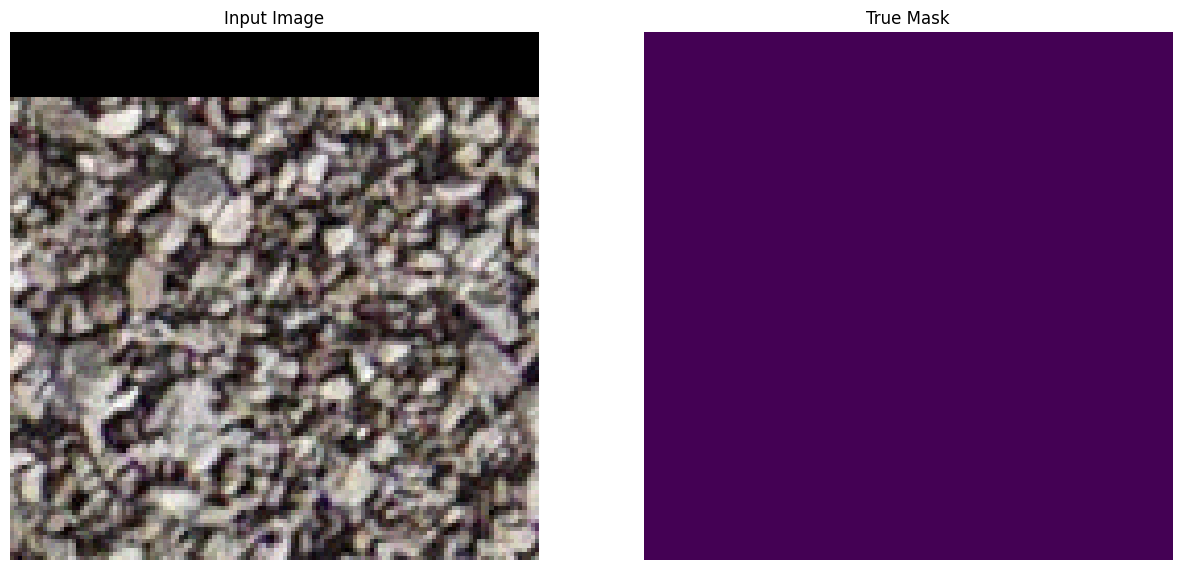

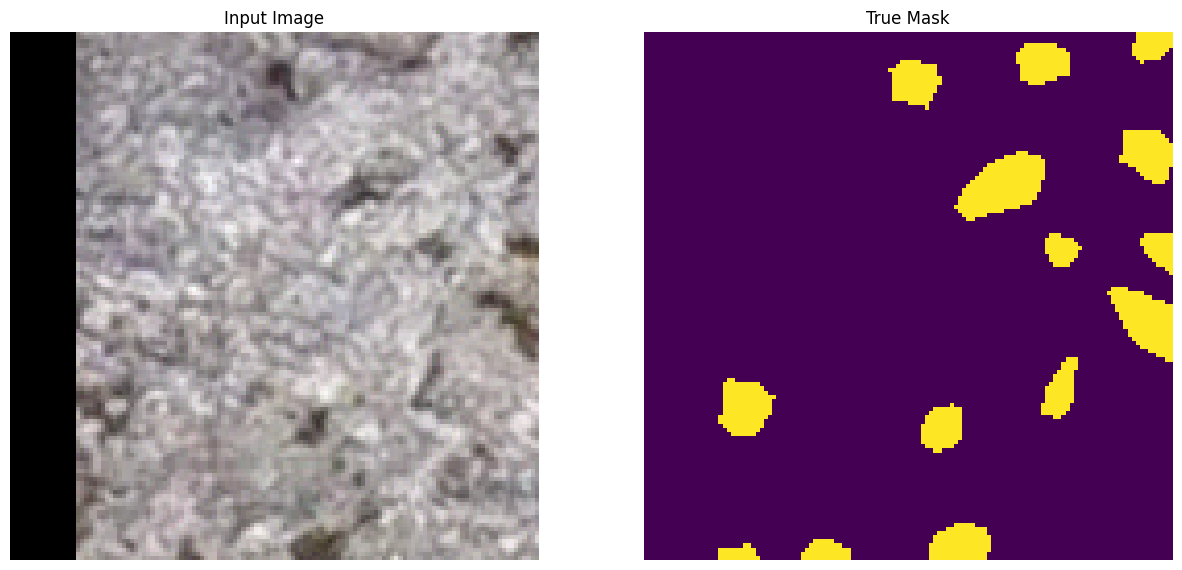

In [14]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same', activation='sigmoid')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
OUTPUT_CLASSES = 1  # Single-channel output mask

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',
                       tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.TruePositives()])




EPOCHS = 20
VAL_SUBSPLITS = 5

train_examples = train_ds.reduce(0, lambda x,_: x+1).numpy()
test_examples = test_ds.reduce(0, lambda x,_: x+1).numpy()

STEPS_PER_EPOCH = train_examples // BATCH_SIZE


VALIDATION_STEPS = test_examples//BATCH_SIZE//VAL_SUBSPLITS

train_weights = [1, 1]#get_class_weights(train_ds)

model_history = model.fit(train_batches.map(lambda x, y: add_sample_weights(x, y, train_weights)),
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/20
102/102 [==============================] - 9s 37ms/step - loss: 0.1935 - accuracy: 0.7876 - false_negatives_1: 78417.0000 - false_positives_1: 1341611.0000 - true_negatives_1: 5243725.0000 - true_positives_1: 20919.0000 - val_loss: 0.2259 - val_accuracy: 0.9501 - val_false_negatives_1: 5625.0000 - val_false_positives_1: 10711.0000 - val_true_negatives_1: 311059.0000 - val_true_positives_1: 285.0000
Epoch 2/20
102/102 [==============================] - 3s 27ms/step - loss: 0.0855 - accuracy: 0.9770 - false_negatives_1: 98485.0000 - false_positives_1: 54998.0000 - true_negatives_1: 6530338.0000 - true_positives_1: 851.0000 - val_loss: 0.1825 - val_accuracy: 0.9680 - val_false_negatives_1: 10305.0000 - val_false_positives_1: 170.0000 - val_true_negatives_1: 317202.0000 - val_true_positives_1: 3.0000
Epoch 3/20
102/102 [==============================] - 2s 24ms/step - loss: 0.0552 - accuracy: 0.9849 - false_negatives_1: 99275.0000 - false_positives_1: 1366.0000 - true_negatives_

In [24]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'false_negatives_1', 'false_positives_1', 'true_negatives_1', 'true_positives_1', 'val_loss', 'val_accuracy', 'val_false_negatives_1', 'val_false_positives_1', 'val_true_negatives_1', 'val_true_positives_1'])

dict_keys(['loss', 'accuracy', 'false_negatives_1', 'false_positives_1', 'true_negatives_1', 'true_positives_1', 'val_loss', 'val_accuracy', 'val_false_negatives_1', 'val_false_positives_1', 'val_true_negatives_1', 'val_true_positives_1'])


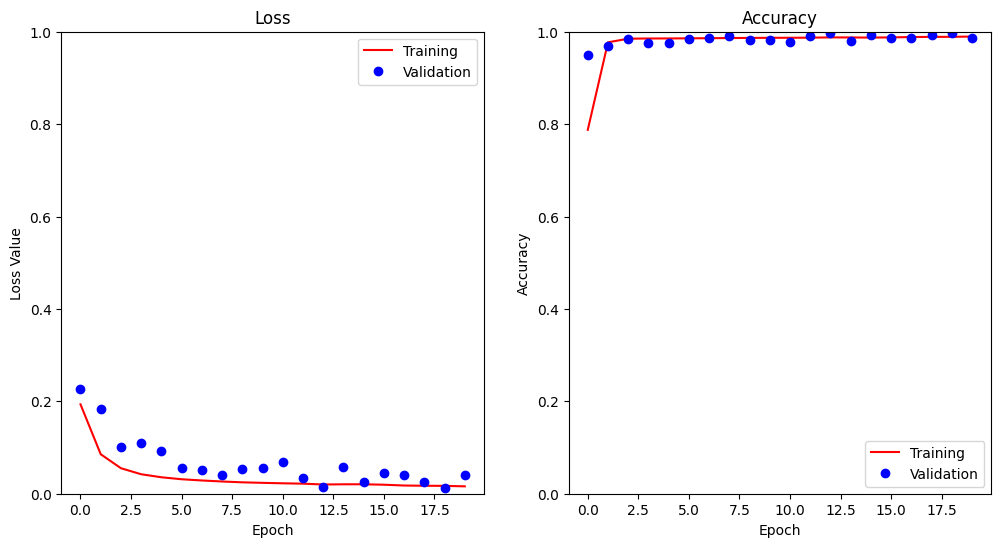

In [29]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

print(model_history.history.keys())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].plot(model_history.epoch, loss, 'r', label='Training')
ax[0].plot(model_history.epoch, val_loss, 'bo', label='Validation')
ax[0].set_title('Loss')
ax[0].set_ylabel('Loss Value')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim([0, 1])
ax[0].legend(loc="upper right")

ax[1].plot(model_history.epoch, accuracy, 'r', label='Training')
ax[1].plot(model_history.epoch, val_accuracy, 'bo', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim([0, 1])
ax[1].legend(loc="lower right");



Text(0.5, 0, 'Epoch')

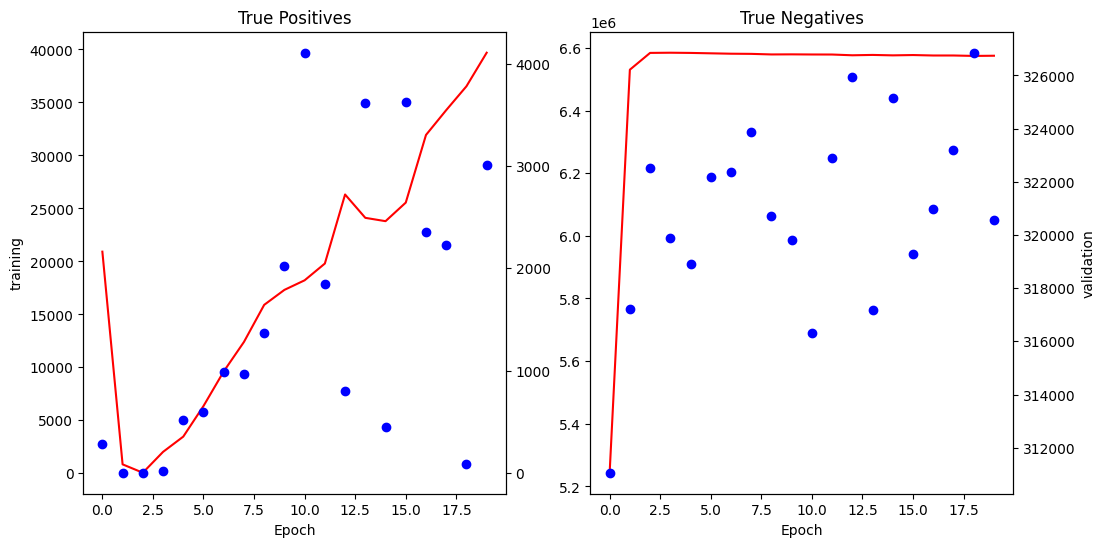

In [35]:
tp = model_history.history['true_positives_1']
val_tp = model_history.history['val_true_positives_1']

tn = model_history.history['true_negatives_1']
val_tn = model_history.history['val_true_negatives_1']

# x = model_history.epoch

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax_0_1 = ax[0]
ax_0_2 = ax[0].twinx()

ax_0_1.plot(model_history.epoch, tp, 'r', label='Training')
ax_0_2.plot(model_history.epoch, val_tp, 'bo', label='Validation')
ax_0_1.set_title('True Positives')
ax_0_1.set_ylabel('training')
# ax_0_2.set_ylabel('validation')
ax_0_1.set_xlabel('Epoch')
###############
ax_1_1 = ax[1]
ax_1_2 = ax[1].twinx()

ax_1_1.plot(model_history.epoch, tn, 'r', label='Training')
ax_1_2.plot(model_history.epoch, val_tn, 'bo', label='Validation')
ax_1_1.set_title('True Negatives')
# ax_1_1.set_ylabel('training')
ax_1_2.set_ylabel('validation')
ax_1_1.set_xlabel('Epoch')


Text(0.5, 0, 'Epoch')

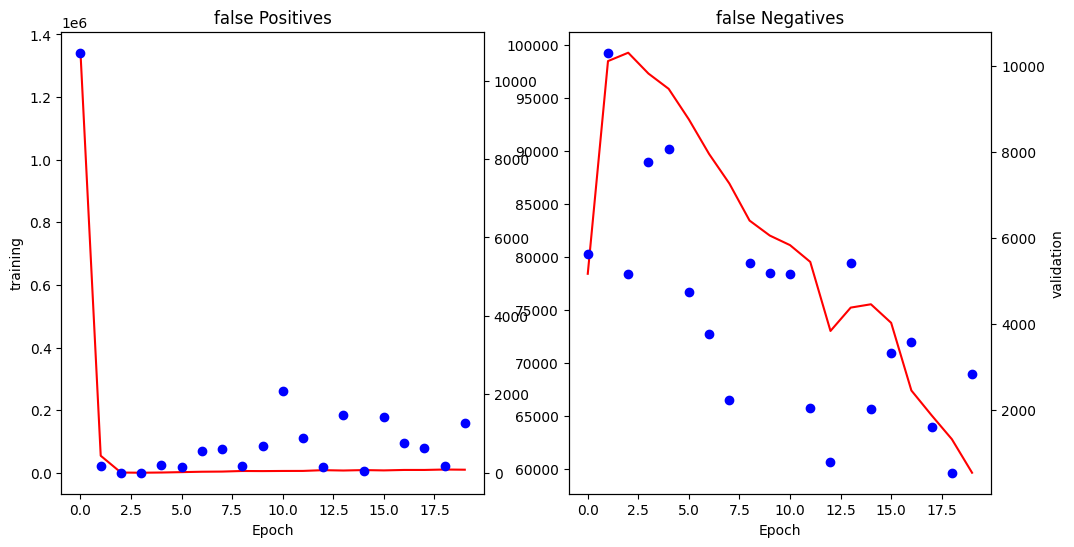

In [36]:
fp = model_history.history['false_positives_1']
val_fp = model_history.history['val_false_positives_1']

fn = model_history.history['false_negatives_1']
val_fn = model_history.history['val_false_negatives_1']

# x = model_history.epoch

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax_0_1 = ax[0]
ax_0_2 = ax[0].twinx()

ax_0_1.plot(model_history.epoch, fp, 'r', label='Training')
ax_0_2.plot(model_history.epoch, val_fp, 'bo', label='Validation')
ax_0_1.set_title('false Positives')
ax_0_1.set_ylabel('training')
# ax_0_2.set_ylabel('validation')
ax_0_1.set_xlabel('Epoch')
###############
ax_1_1 = ax[1]
ax_1_2 = ax[1].twinx()

ax_1_1.plot(model_history.epoch, fn, 'r', label='Training')
ax_1_2.plot(model_history.epoch, val_fn, 'bo', label='Validation')
ax_1_1.set_title('false Negatives')
# ax_1_1.set_ylabel('training')
ax_1_2.set_ylabel('validation')
ax_1_1.set_xlabel('Epoch')

1/1 [==============================] - 1s 937ms/step


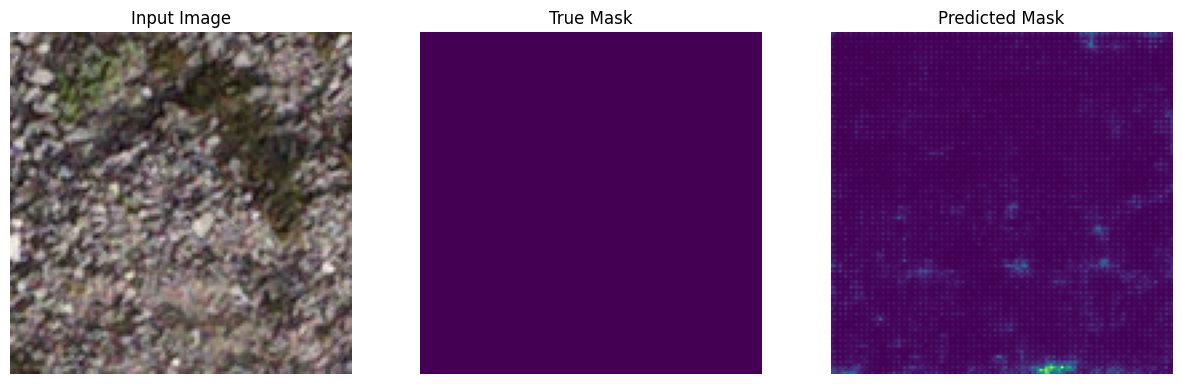

1/1 [==============================] - 0s 37ms/step


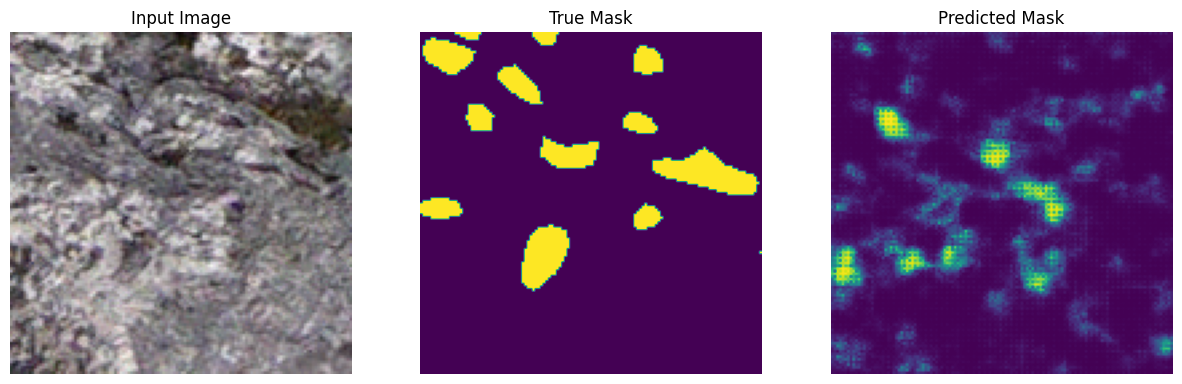

1/1 [==============================] - 0s 30ms/step


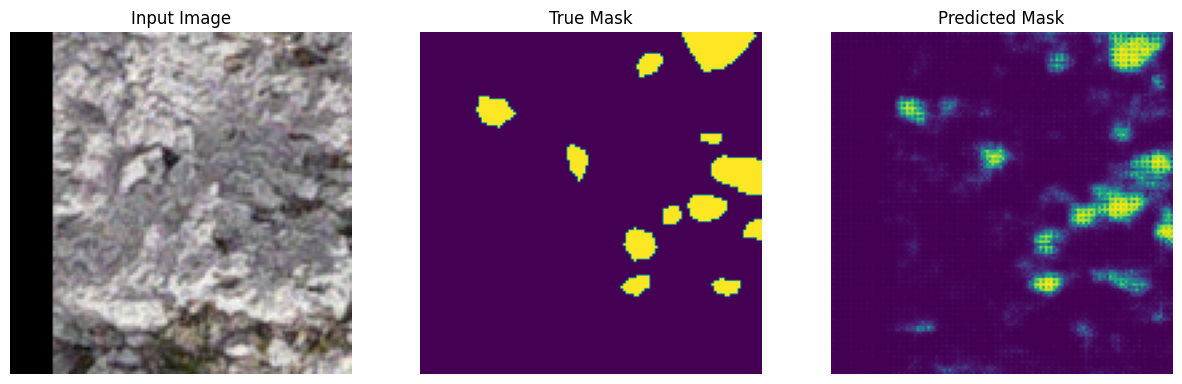

1/1 [==============================] - 0s 33ms/step


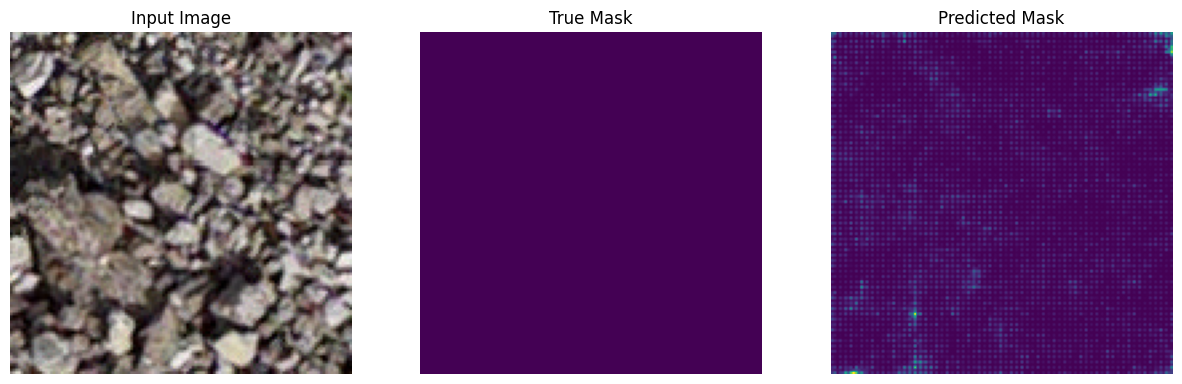

1/1 [==============================] - 0s 27ms/step


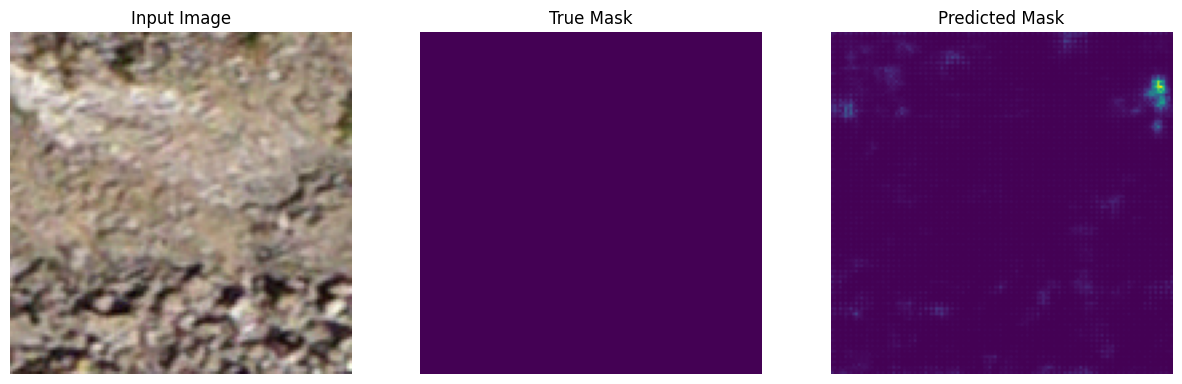

1/1 [==============================] - 0s 25ms/step


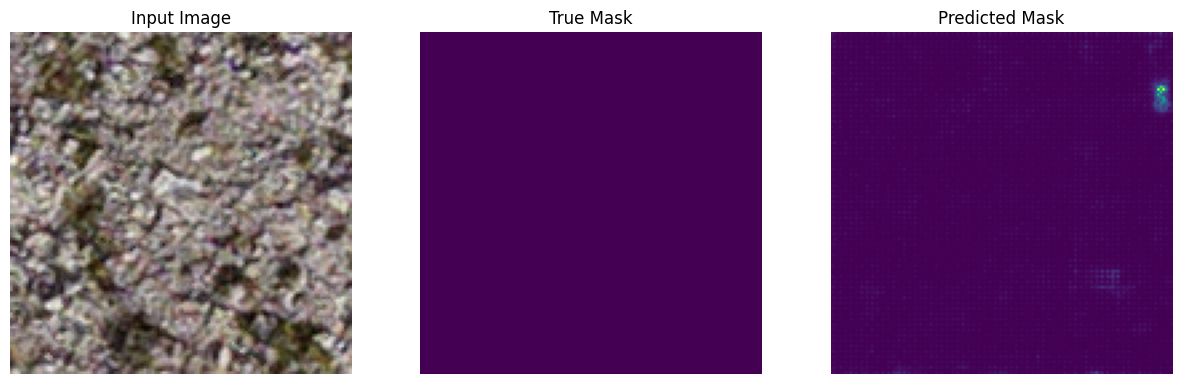

1/1 [==============================] - 0s 25ms/step


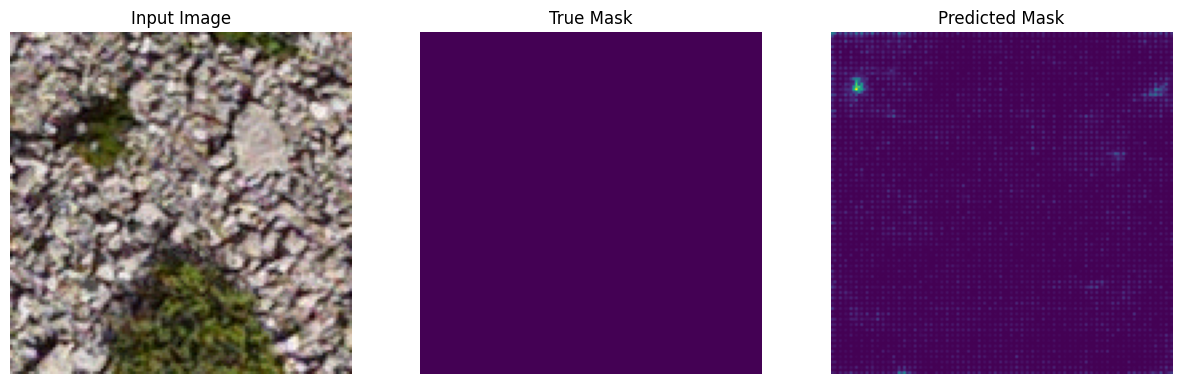

1/1 [==============================] - 0s 38ms/step


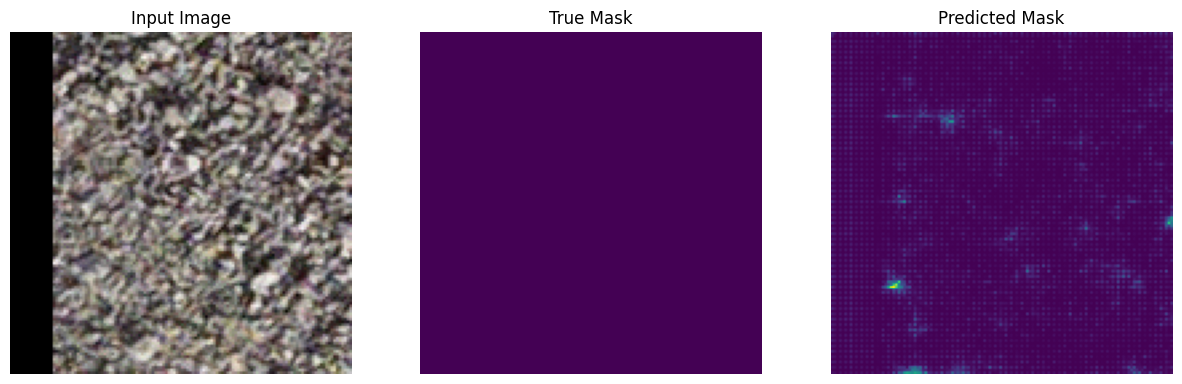

In [38]:
for img, mask in test_batches.take(8):

  i1, m1, pred = img[0], mask[0], model.predict(img)[0]

  display([ i1, m1, pred])